In [1]:
# General imports
import numpy as np

# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp

# SciPy minimizer routine
from scipy.optimize import minimize

# Plotting functions
import matplotlib.pyplot as plt

In [2]:
from qiskit_ibm_runtime import QiskitRuntimeService

# Save an IBM Cloud account on disk
token = 'a9eb29bb95b80902e25e92793712fec6704c61eb1b875dd3a00eee41a52a499744985608913bad9fbb354d4c513bc5d43d5a92a2646c135045a675e57808abba'  # <== Use your token here
QiskitRuntimeService.save_account(channel="ibm_quantum", token=token, overwrite=True)

In [3]:
# runtime imports
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator

# To run on hardware, select the backend with the fewest number of jobs in the queue
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True, simulator=False)


In [4]:
type(backend)

qiskit_ibm_runtime.ibm_backend.IBMBackend

In [5]:
status = backend.status()
print(status)

In [6]:
print(status.to_dict())

{'backend_name': 'ibm_brisbane', 'backend_version': '', 'operational': True, 'pending_jobs': 37, 'status_msg': 'active'}


In [7]:
print(status.operational)

True


In [8]:
print(status.pending_jobs)

37


In [9]:
print(dir(status))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_repr_html_', 'backend_name', 'backend_version', 'from_dict', 'operational', 'pending_jobs', 'status_msg', 'to_dict']


In [4]:
hamiltonian = SparsePauliOp.from_list(
    [("YZ", 0.3980), ("ZI", -0.3980), ("ZZ", -0.0113), ("XX", 0.1810)]
)

In [5]:
hamiltonian.num_qubits

2

In [11]:
type(hamiltonian)

qiskit.quantum_info.operators.symplectic.sparse_pauli_op.SparsePauliOp

In [12]:
hamiltonian.coeffs

array([ 0.398 +0.j, -0.398 +0.j, -0.0113+0.j,  0.181 +0.j])

In [13]:
hamiltonian.coeffs.dtype

dtype('complex128')

In [14]:
hamiltonian.paulis

PauliList(['YZ', 'ZI', 'ZZ', 'XX'])

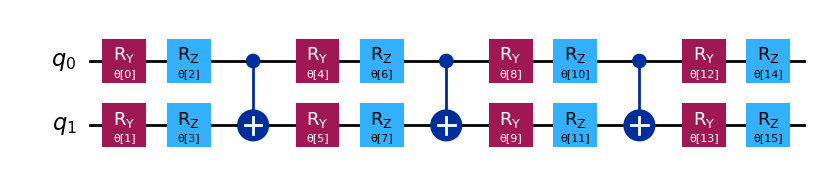

In [6]:
ansatz = EfficientSU2(hamiltonian.num_qubits)
ansatz.decompose().draw("mpl", style="iqp")

In [7]:
ansatz = EfficientSU2(hamiltonian.num_qubits)
result = ansatz.decompose()
print(type(result))

<class 'qiskit.circuit.quantumcircuit.QuantumCircuit'>


In [17]:
result = ansatz.decompose().draw("mpl", style="iqp")
print(type(result))

<class 'matplotlib.figure.Figure'>


In [18]:
print(type(ansatz.layout))


<class 'NoneType'>


In [19]:
type(ansatz)

qiskit.circuit.library.n_local.efficient_su2.EfficientSU2

In [14]:
num_params = ansatz.num_parameters
num_params

16

In [8]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

ansatz_isa = pm.run(ansatz)

In [22]:
print(type(ansatz_isa.layout))

<class 'qiskit.transpiler.layout.TranspileLayout'>


In [22]:
type(pm)

qiskit.transpiler.passmanager.StagedPassManager

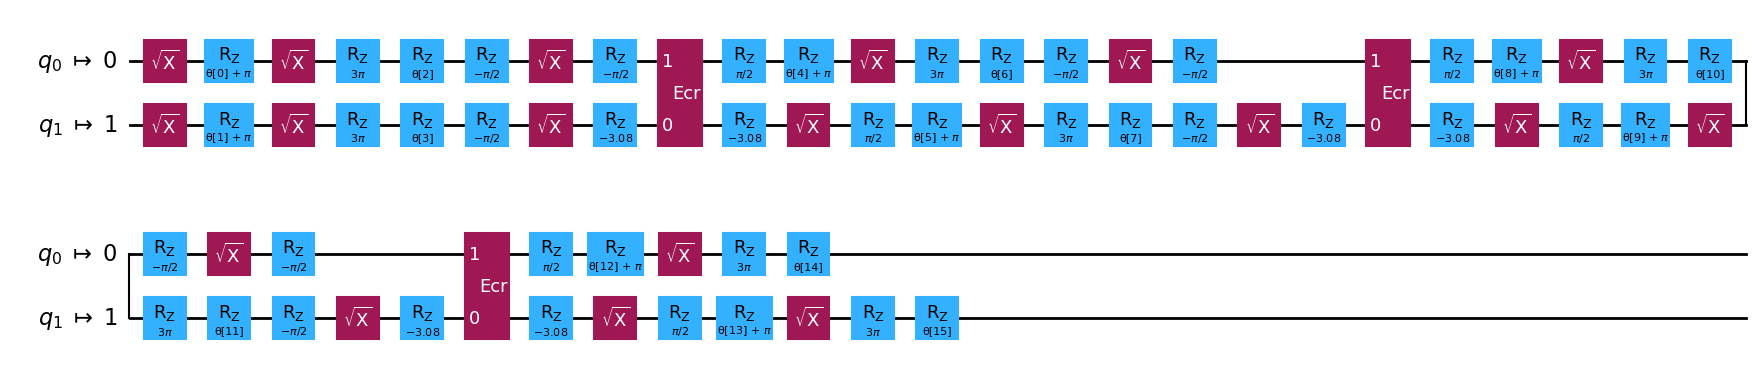

In [9]:
ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [10]:
hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)

In [11]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]
    
    print("Type of result:", type(result))
    print("Type of energy:", type(energy))

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy

In [12]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

In [15]:
x0 = 2 * np.pi * np.random.random(num_params)

In [20]:
x0

array([3.16251316, 0.50596885, 5.18666013, 2.21310832, 0.33578969,
       4.35841009, 3.26918393, 4.21467398, 1.21366202, 4.2626165 ,
       1.11197276, 1.84210633, 1.51115791, 1.95862157, 3.33112737,
       6.25826863])

In [21]:
type(x0)

numpy.ndarray

In [16]:
with Session(backend=backend) as mode:
    estimator = Estimator(mode=mode)
    estimator.options.default_shots = 5000  # Reduce the number of shots to speed up each job
    
    options = {
        'maxiter': 50,  # Example: still keeping max iterations
        'rhobeg': 0.5,   # Starting value for the trust region radius
        'tol': 1e-3      # Final accuracy of the optimization
    }

    res = minimize(
        cost_func,
        x0,
        args=(hamiltonian_isa, ansatz_isa, estimator),
        method="cobyla",
        options=options
    )

TypeError: Invalid observable type: <class 'qiskit.circuit.quantumcircuit.QuantumCircuit'>

In [ ]:
res

In [ ]:
all(cost_history_dict["prev_vector"] == res.x)

In [ ]:
cost_history_dict["iters"] == res.nfev

<class 'NoneType'>


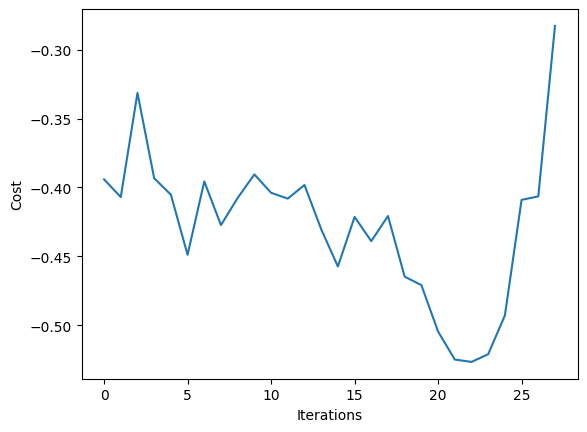

In [29]:
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
result = plt.draw()
print(type(result))

In [ ]:
import qiskit_ibm_runtime

qiskit_ibm_runtime.version.get_version_info()

In [ ]:
import qiskit

qiskit.version.get_version_info()